In [1]:
import kmodes
from kmodes.kmodes.kmodes import KModes

In [2]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *

In [3]:
# 하이퍼파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25 #############
    seed = 42
    neg_ratio = 100 #######
    test_size = 0.2

In [4]:
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [5]:
# 경로 설정
data_path = './data'
saved_path = './code/saved'
output_path = './code/submission'

In [6]:
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')
watch_e_df = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
search_df =  pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')
buy_df = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')
meta_plus_df = pd.read_csv(os.path.join(data_path, 'meta_data_plus.csv'), encoding='utf-8')

In [7]:
meta_df_new = meta_df[['album_id','run_time']]

In [8]:
meta_df_new = meta_df_new.drop_duplicates()

In [9]:
meta_df_new

,album_id,run_time
0,749,660
1,750,660
2,2131,660
3,2625,660
4,2594,660
...,...,...
42596,39872,443
42597,39873,477
42598,39874,466
42599,4779,293


In [10]:
meta_df_new.album_id.value_counts()

749      1
17056    1
15212    1
12126    1
12124    1
        ..
5407     1
5406     1
32275    1
22598    1
11629    1
Name: album_id, Length: 39875, dtype: int64

In [11]:
meta_df.loc[meta_df['album_id']==8231]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
13526,8231,알록달록 물고기,노래율동,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13527,8231,알록달록 물고기,만 3세를 위한 영상,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13528,8231,알록달록 물고기,만 4세를 위한 영상,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13529,8231,알록달록 물고기,트니트니 율동 바다스페셜,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
meta_watch_merge = pd.merge(left=watch_e_df, right = meta_df_new,how='left', on=['album_id'])

In [13]:
meta_watch_merge

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,run_time
0,3,20220301115653,20220301115805,MKID049,15,46,46,1,46
1,3,20220301115653,20220301115954,MKID049,16,104,105,1,105
2,3,20220301115653,20220301120114,MKID049,17,76,76,1,76
3,3,20220301115653,20220301120226,MKID049,18,67,68,1,68
4,3,20220301115653,20220301120400,MKID049,19,90,90,0,90
...,...,...,...,...,...,...,...,...,...
892789,33032,20220427155091,20220427155653,MKID049,381,463,464,1,462
892790,33032,20220427155091,20220427155694,MKID049,381,462,463,1,462
892791,33032,20220427155839,20220427155826,MKID049,125,10,520,0,520
892792,33032,20220427155706,20220427155836,MKID049,125,6,521,0,520


In [14]:
meta_watch_merge = meta_watch_merge.sort_values(by = ['profile_id','album_id'])

In [15]:
meta_watch_merge['watch_ratio'] = meta_watch_merge['watch_time']/meta_watch_merge['run_time']

In [16]:
meta_watch_merge1 = meta_watch_merge.loc[meta_watch_merge['watch_ratio']>1]

In [17]:
meta_watch_merge2 = meta_watch_merge.loc[meta_watch_merge['watch_ratio']<=1]

In [18]:
meta_watch_merge1['watch_ratio']=1.0

In [19]:
meta_watch_merge1

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,run_time,watch_ratio
333,5,20220326133022,20220326133135,MKID049,15,47,47,1,46,1.0
30,5,20220306110942,20220306111509,MKID049,74,301,301,1,300,1.0
101,5,20220309185728,20220309191241,MKID049,130,173,173,1,172,1.0
128,5,20220310180411,20220311082033,MKID049,130,173,173,1,172,1.0
279,5,20220322200537,20220322202833,MKID049,130,173,173,1,172,1.0
...,...,...,...,...,...,...,...,...,...,...
892670,33032,20220426134684,20220426135076,MKID049,2200,125,127,1,99,1.0
892677,33032,20220426134684,20220426135271,MKID049,2297,360,362,1,121,1.0
892718,33032,20220427110951,20220427111624,MKID049,2573,724,725,1,720,1.0
892661,33032,20220426131390,20220426131303,MKID049,7105,360,362,1,321,1.0


In [20]:
meta_watch_merge2

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,run_time,watch_ratio
0,3,20220301115653,20220301115805,MKID049,15,46,46,1,46,1.000000
1,3,20220301115653,20220301115954,MKID049,16,104,105,1,105,0.990476
2,3,20220301115653,20220301120114,MKID049,17,76,76,1,76,1.000000
3,3,20220301115653,20220301120226,MKID049,18,67,68,1,68,0.985294
4,3,20220301115653,20220301120400,MKID049,19,90,90,0,90,1.000000
...,...,...,...,...,...,...,...,...,...,...
892748,33032,20220427144943,20220427144974,MKID049,8838,302,303,1,303,0.996700
892655,33032,20220426115550,20220426130515,MKID049,8910,300,301,1,300,1.000000
892648,33032,20220426114717,20220426114966,MKID049,15663,9,1417,0,1419,0.006342
892770,33032,20220427150528,20220427150920,MKID049,18334,64,65,1,75,0.853333


In [21]:
merge_tot = pd.concat([meta_watch_merge1,meta_watch_merge2])

In [22]:
merge_tot.album_id.nunique()

20361

In [23]:
merge_tot.sort_values(by=['profile_id','album_id','watch_ratio'])

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,run_time,watch_ratio
0,3,20220301115653,20220301115805,MKID049,15,46,46,1,46,1.000000
1,3,20220301115653,20220301115954,MKID049,16,104,105,1,105,0.990476
2,3,20220301115653,20220301120114,MKID049,17,76,76,1,76,1.000000
3,3,20220301115653,20220301120226,MKID049,18,67,68,1,68,0.985294
4,3,20220301115653,20220301120400,MKID049,19,90,90,0,90,1.000000
...,...,...,...,...,...,...,...,...,...,...
892746,33032,20220427144924,20220427144918,MKID049,8838,303,304,1,303,1.000000
892655,33032,20220426115550,20220426130515,MKID049,8910,300,301,1,300,1.000000
892648,33032,20220426114717,20220426114966,MKID049,15663,9,1417,0,1419,0.006342
892771,33032,20220427150528,20220427150995,MKID049,18334,1,74,0,75,0.013333


In [24]:
tb1 = merge_tot[['profile_id','album_id','watch_ratio']].groupby(['profile_id','album_id']).sum('watch_ratio').reset_index()

In [25]:
tb1.loc[tb1['watch_ratio']<0.2]

,profile_id,album_id,watch_ratio
36,5,66,0.043584
66,5,96,0.000000
71,5,101,0.065217
108,5,138,0.018182
120,5,150,0.194805
...,...,...,...
347971,33032,4944,0.000000
347973,33032,5256,0.000000
347974,33032,6577,0.034319
347976,33032,7010,0.000000


In [26]:
tb1['watch_ratio'].sort_values(ascending=False)

38990     1911.375000
38972      942.426966
38983      867.219780
38989      858.967391
38971      684.343137
             ...     
305132       0.000000
251281       0.000000
251285       0.000000
47380        0.000000
101333       0.000000
Name: watch_ratio, Length: 347982, dtype: float64

In [27]:
tb1.loc[tb1['watch_ratio']>1900,:]

,profile_id,album_id,watch_ratio
38990,2794,3502,1911.375


In [28]:
merge_tot.loc[(merge_tot['profile_id']==2794) & (merge_tot['album_id']==3502)]

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,run_time,watch_ratio
98959,2794,20220301000888,20220301001043,MKID049,3502,91,93,1,80,1.0
98960,2794,20220301000888,20220301001043,MKID049,3502,91,93,1,80,1.0
98961,2794,20220301000888,20220301001043,MKID049,3502,91,93,1,80,1.0
98962,2794,20220301000888,20220301001043,MKID049,3502,91,93,1,80,1.0
98979,2794,20220301000888,20220301002071,MKID049,3502,91,91,1,80,1.0
...,...,...,...,...,...,...,...,...,...,...
111390,2794,20220422131982,20220422134467,MKID049,3502,80,80,1,80,1.0
111391,2794,20220422131982,20220422134467,MKID049,3502,80,80,1,80,1.0
111404,2794,20220422131982,20220422135204,MKID049,3502,80,80,1,80,1.0
111405,2794,20220422131982,20220422135204,MKID049,3502,80,80,1,80,1.0


In [29]:
tb1

,profile_id,album_id,watch_ratio
0,3,15,1.000000
1,3,16,0.990476
2,3,17,1.000000
3,3,18,0.985294
4,3,19,1.000000
...,...,...,...
347977,33032,7105,5.404984
347978,33032,8838,1.996700
347979,33032,8910,1.000000
347980,33032,15663,0.006342


In [30]:
meta_genre_mid = meta_df[['album_id','genre_mid']].drop_duplicates()

In [31]:
pd.merge(left=merge_tot,right = meta_genre_mid,how='left',on='album_id')

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,run_time,watch_ratio,genre_mid
0,5,20220326133022,20220326133135,MKID049,15,47,47,1,46,1.000000,노래율동
1,5,20220306110942,20220306111509,MKID049,74,301,301,1,300,1.000000,TV만화
2,5,20220309185728,20220309191241,MKID049,130,173,173,1,172,1.000000,노래율동
3,5,20220310180411,20220311082033,MKID049,130,173,173,1,172,1.000000,노래율동
4,5,20220322200537,20220322202833,MKID049,130,173,173,1,172,1.000000,노래율동
...,...,...,...,...,...,...,...,...,...,...,...
892789,33032,20220427144943,20220427144974,MKID049,8838,302,303,1,303,0.996700,외국어
892790,33032,20220426115550,20220426130515,MKID049,8910,300,301,1,300,1.000000,TV만화
892791,33032,20220426114717,20220426114966,MKID049,15663,9,1417,0,1419,0.006342,외국어
892792,33032,20220427150528,20220427150920,MKID049,18334,64,65,1,75,0.853333,외국어


In [32]:
tb2 = pd.merge(left=tb1,right = meta_genre_mid,how='left',on='album_id')

In [33]:
tb3 = tb2[['profile_id','album_id']].groupby(['profile_id']).nunique('alnum_id').reset_index()

In [34]:
tb3.rename(columns = {'album_id': 'album_id_cnt'},inplace=True)

In [35]:
tb4 = pd.merge(left=tb1,right = tb3 ,how='left',on='profile_id')

In [36]:
tb4.sort_values(by=['profile_id','watch_ratio'])

,profile_id,album_id,watch_ratio,album_id_cnt
13,3,28,0.975207,18
7,3,22,0.983471,18
9,3,24,0.983471,18
10,3,25,0.983471,18
11,3,26,0.983471,18
...,...,...,...,...
347927,33032,350,3.956944,66
347917,33032,65,4.966418,66
347928,33032,373,5.360000,66
347977,33032,7105,5.404984,66


In [37]:
### 빌어먹을 노래율동 하나로 합치기
meta_df['genre_mid'][meta_df['genre_mid'] == '노래 율동'] = '노래율동'

In [38]:
### 중복 제거
no_dup_meta = meta_df.drop_duplicates(subset="album_id")

In [39]:
### 데이터 로드
data = pd.read_pickle('tag_for_all_id.pickle')

In [40]:
### 데이터 합치기
usedata = pd.merge(data, no_dup_meta[['album_id', 'genre_mid', 'cast_1']], left_on = 'album_id', right_on = "album_id", how = 'inner')

In [41]:
### 결측치에 Unknown 채우기
lastdata = usedata.fillna("Unknown")

## Kmodes clustering

In [42]:
km = KModes(n_clusters=2, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(lastdata)

# Print the cluster centroids
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7389, cost: 111520.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 826, cost: 115601.0
Run 2, iteration: 2/100, moves: 340, cost: 115364.0
Run 2, iteration: 3/100, moves: 8, cost: 115364.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 7168, cost: 108992.0
Run 3, iteration: 2/100, moves: 1382, cost: 108992.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 125030.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 9626, cost: 108992.0
Run 5, iteration: 2/100, moves: 5761, cost: 108992.0
Best run was number 3
[['0' '스토리 애니' 'TV만화' 'Unknown']
 ['317' '교육' '놀이교실' 'Unknown']]



# of cluster :  range(1, 20) 

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 125133.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 125133.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 125133.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 125133.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 125133.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 125133.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 0, cost: 125133.0
Init: initializing centroids
Init: initializing clusters
S

Starting iterations...
Run 2, iteration: 1/100, moves: 3142, cost: 95538.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 5607, cost: 95241.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10177, cost: 92391.0
Run 4, iteration: 2/100, moves: 378, cost: 92391.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 10276, cost: 92659.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 6508, cost: 97326.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 8096, cost: 102745.0
Run 7, iteration: 2/100, moves: 11427, cost: 98161.0
Run 7, iteration: 3/100, moves: 2609, cost: 98161.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, iteration: 1/100, m

Starting iterations...
Run 7, iteration: 1/100, moves: 3284, cost: 94219.0
Run 7, iteration: 2/100, moves: 30, cost: 94219.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, iteration: 1/100, moves: 3721, cost: 93628.0
Run 8, iteration: 2/100, moves: 1124, cost: 93435.0
Run 8, iteration: 3/100, moves: 42, cost: 93435.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 9, iteration: 1/100, moves: 9078, cost: 89512.0
Run 9, iteration: 2/100, moves: 2375, cost: 89512.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 10, iteration: 1/100, moves: 4993, cost: 89925.0
Best run was number 1

# of cluster :  range(1, 20) 

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5627, cost: 88640.0
Run 1, iteration: 2/100, moves: 99, cost: 88640.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, i

Starting iterations...
Run 7, iteration: 1/100, moves: 9692, cost: 83439.0
Run 7, iteration: 2/100, moves: 1352, cost: 83439.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, iteration: 1/100, moves: 12431, cost: 84720.0
Run 8, iteration: 2/100, moves: 924, cost: 84719.0
Run 8, iteration: 3/100, moves: 0, cost: 84719.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 9, iteration: 1/100, moves: 7740, cost: 86365.0
Run 9, iteration: 2/100, moves: 1659, cost: 86364.0
Run 9, iteration: 3/100, moves: 0, cost: 86364.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 10, iteration: 1/100, moves: 9324, cost: 86715.0
Run 10, iteration: 2/100, moves: 1127, cost: 86715.0
Best run was number 4

# of cluster :  range(1, 20) 

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11666, cost: 84941.0
Run 1, iteration: 2/100, moves: 11

Run 6, iteration: 3/100, moves: 41, cost: 85597.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 10641, cost: 85547.0
Run 7, iteration: 2/100, moves: 873, cost: 85543.0
Run 7, iteration: 3/100, moves: 0, cost: 85543.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, iteration: 1/100, moves: 4908, cost: 84289.0
Run 8, iteration: 2/100, moves: 161, cost: 84288.0
Run 8, iteration: 3/100, moves: 0, cost: 84288.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 9, iteration: 1/100, moves: 11099, cost: 84942.0
Run 9, iteration: 2/100, moves: 1703, cost: 84942.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 10, iteration: 1/100, moves: 5283, cost: 84175.0
Run 10, iteration: 2/100, moves: 641, cost: 84175.0
Best run was number 5

# of cluster :  range(1, 20) 

Init: initializing centroids
Init: initializing clusters
Star

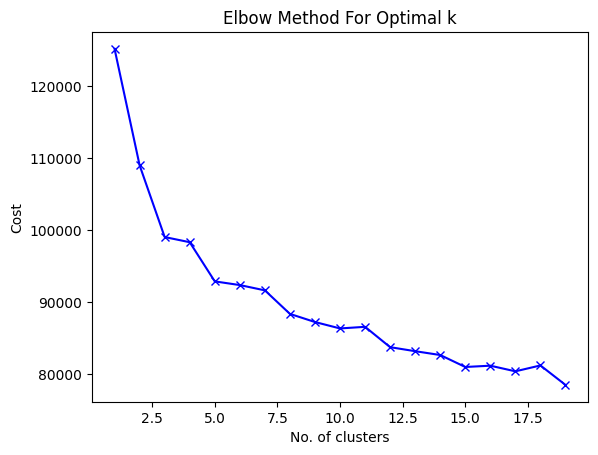

In [43]:
### Elbow curve to find optimal K
cost = []
K = range(1,20)
for num_clusters in list(K):
    print("\n# of cluster : ",num_clusters,"\n")
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 10, verbose = 1, random_state = 42)
    kmode.fit_predict(lastdata)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [48]:
km = KModes(n_clusters=5, init='Huang', n_init=10, verbose=1, random_state=42)

clusters = km.fit_predict(lastdata)

# Print the cluster centroids
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14728, cost: 95889.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8010, cost: 94869.0
Run 2, iteration: 2/100, moves: 40, cost: 94869.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 10590, cost: 92902.0
Run 3, iteration: 2/100, moves: 392, cost: 92902.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 9616, cost: 95330.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 9680, cost: 102920.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 2166, cost: 100927.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100

In [49]:
km = KModes(n_clusters=8, init='Huang', n_init=10, verbose=1, random_state=42)

clusters2 = km.fit_predict(lastdata)

# Print the cluster centroids
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7025, cost: 89348.0
Run 1, iteration: 2/100, moves: 4594, cost: 89348.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 6626, cost: 91322.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 16247, cost: 90515.0
Run 3, iteration: 2/100, moves: 4181, cost: 88394.0
Run 3, iteration: 3/100, moves: 487, cost: 88394.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 4821, cost: 96025.0
Run 4, iteration: 2/100, moves: 306, cost: 96025.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 6577, cost: 95301.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 3642, cost: 94360.0
I

In [50]:
km = KModes(n_clusters=12, init='Huang', n_init=10, verbose=1, random_state=42)

clusters3 = km.fit_predict(lastdata)

# Print the cluster centroids
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3582, cost: 89655.0
Run 1, iteration: 2/100, moves: 8226, cost: 89534.0
Run 1, iteration: 3/100, moves: 209, cost: 89534.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7320, cost: 87371.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9894, cost: 83781.0
Run 3, iteration: 2/100, moves: 3881, cost: 83780.0
Run 3, iteration: 3/100, moves: 0, cost: 83780.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 9001, cost: 90780.0
Run 4, iteration: 2/100, moves: 440, cost: 90779.0
Run 4, iteration: 3/100, moves: 0, cost: 90779.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 5914, cost: 91116.0
Run 5, iteration: 2/100, moves: 359,

In [44]:
pd.Series(clusters).value_counts()

0    27211
1    12664
dtype: int64

In [51]:
cluster = pd.DataFrame(clusters)
cluster2 = pd.DataFrame(clusters2)
cluster3 = pd.DataFrame(clusters3)

In [52]:
clus_df = pd.concat((lastdata, cluster, cluster2, cluster3), axis = 1)
clus_df

,album_id,tag,genre_mid,cast_1,0,0,0
0,749,타요,TV만화,타요,0,2,6
1,750,타요,TV만화,타요,0,2,6
2,2131,타요,TV만화,타요,0,2,6
3,2625,타요,TV만화,타요,0,2,6
4,2594,타요,TV만화,타요,0,2,6
...,...,...,...,...,...,...,...
39870,39872,교육,놀이교실,Unknown,1,1,0
39871,39873,교육,놀이교실,Unknown,1,1,0
39872,39874,교육,놀이교실,Unknown,1,1,0
39873,4779,동화,책,Unknown,3,4,11


In [61]:
clus_df.columns = ['album_id', 't', 't2', 't3', 'clus5', 'clus8', 'clus12']
cl = clus_df[['album_id', 'clus5', 'clus8', 'clus12']]
cl

,album_id,clus5,clus8,clus12
0,749,0,2,6
1,750,0,2,6
2,2131,0,2,6
3,2625,0,2,6
4,2594,0,2,6
...,...,...,...,...
39870,39872,1,1,0
39871,39873,1,1,0
39872,39874,1,1,0
39873,4779,3,4,11


In [63]:
import pickle

In [64]:
### save pickle
with open('clusterset.pickle', 'wb') as f:
    pickle.dump(cl, f)